In [284]:
import qiskit
import math
import random
import numpy as np
from matplotlib import pyplot as plt

# Input:
 Constants epsilon, δ, Λ ∈ (0, 1), and copies of state ρ ∈ C2n×2n .

In [285]:
def generate_rho(ev_delta, n):
	dim = pow(2,n)
	if ev_delta > 1:
		raise ValueError("ev_delta must be less than or equal to 1")
	EV = []
	for i in range(dim):
		if sum(EV) <= 1 - ev_delta:
			phi_ev = random.uniform(ev_delta, 1-sum(EV))
			if 1-sum(EV)-phi_ev-ev_delta < 0:
				phi_ev = 1-sum(EV)
			EV.append(phi_ev)
		else:
			EV.append(0)
	EV = EV
	rho = np.diag(EV)

	Z = np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)
	R, _ = np.linalg.qr(Z)

	rho = R @ rho @ R.conj().T
	return rho

In [286]:
epsilon = 0.2
delta = 0.05
ev_delta = 0.1
n = 1
rho = generate_rho(ev_delta, n)
print(rho)

[[ 0.28018401+0.j         -0.04840408-0.23373267j]
 [-0.04840408+0.23373267j  0.71981599+0.j        ]]


# Algorithm
## Step 1
Compute coefficients L, K, Ml, and b(k)  l as given in Lemma 1.

In [287]:
K = math.ceil(np.log(epsilon*ev_delta)/np.log(1-ev_delta)) # Number of elements in truncated Taylor series
l_part = 0
for i in range(1,K+1):
	l_part += 1/i
l_part = 4 * l_part / epsilon
L = math.log1p(l_part) * 1 / (ev_delta * ev_delta)
M = []
for l in range(math.floor(L)+1):
	Ml = math.ceil(math.sqrt(math.log1p(l_part)*l/2))
	M.append(Ml)

# Calculating blk
def get_B(K, L):
	bkl_matrix = []
	for k in range(1, K + 1):
		bl_array = []
		for l in range(math.floor(L)+1):
			if k == 1:
				if l%2 == 0:
					blk = 0.0
				else:
					blk = 2 * math.comb(l-1,int((l-1)/2))/(math.pi*math.pow(2,l-1)*l)
				bl_array.append(blk)
			else:
				blk = 0.0
				for l_prime in range(l+1):
					blk += bkl_matrix[k-2][l_prime]*bkl_matrix[0][l-l_prime]
				bl_array.append(blk)

		bkl_matrix.append(bl_array)

	return bkl_matrix

B = get_B(K, L)

U = []
for l in range(math.floor(L+1)):
	Ul = min(l,math.ceil(L/2)+M[l])
	U.append(Ul)

D = []
for l in range(math.floor(L+1)):
	Dl = max(0, math.floor(l/2)-M[l])
	D.append(Dl)

def t(s,l):
	return (2*s-l)*math.pi/2

# Variables K, l, M, B, U, D, t

## Step 2
 Compute ‖f ‖l_1 , as given in Eq. (31).

In [288]:
def get_f(s,l):
	k_sum= 0
	for k in range(1,K+1):
		k_sum += B[k-1][l]/k
	return k_sum*math.comb(l,s)/math.pow(2,l)

F = np.array([])
for l in range(math.floor(L)+1):
	for s in range(D[l],U[l]+1):
		f = get_f(s,l)
		F = np.append(F, f)

F_norm = np.linalg.norm(F, ord = 1)
print(F_norm)

3.3676828881440906


## Step 3
Set estimation error ε = epsilon/‖f ‖l_1

In [289]:
error = epsilon/F_norm
print(error)

0.05938801444283811


## Step 4
Set integer N = ∑bLc  l=0(2Ml + 1).

In [290]:
N = 0
for l in range(math.floor(L)-1):
	N += 2*M[l]+1
print(N)

19399


## Step 5
Define a distribution as in Eq. (32).

(0.4167158410808449+0j)


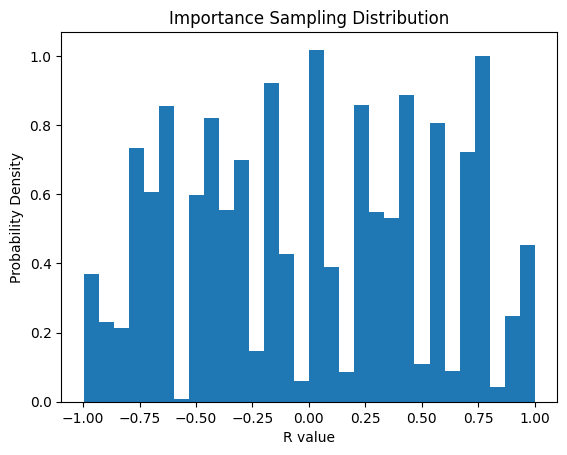

In [291]:
class ImportanceSampling:
	def __init__(self, rho, D, U, F_norm):
		self.samples = []
		current_max = 0
		for l in range(math.floor(L)+1):
			for s in range(D[l],U[l]+1):
				R = np.trace(rho*np.cos(rho*(2*s-l)*math.pi/2))
				prob_density = get_f(s,l)/F_norm
				current_max += prob_density
				pair = [current_max, R]
				self.samples.append(pair)

	def generate_sample(self):
		rand_val = random.uniform(0,1)
		for i in range(len(self.samples)):
			if rand_val <= self.samples[i][0]:
				return self.samples[i][1]

importance_sampler = ImportanceSampling(rho, D, U, F_norm)
sample = importance_sampler.generate_sample()
print(sample)

R_values = [s[1] for s in importance_sampler.samples]

plt.hist(R_values, bins=30, density=True)
plt.xlabel("R value")
plt.ylabel("Probability Density")
plt.title("Importance Sampling Distribution")
plt.show()

## Step 6
Set integer B = #Samples as in Eq. (34).

In [292]:
B_n_samples = round((F_norm/epsilon)**2*np.log(2/delta))
print(f"Required number of samples: {B_n_samples}")

Required number of samples: 1046


## Step 7
Sample B pairs of (s1, l1), . . ., (sB, lB).

In [297]:
B_samples = []
for b in range(1,B_n_samples+1):
	sample = importance_sampler.generate_sample()
	B_samples.append(sample)
b_samples = np.array(B_samples)

print(B_samples[:5])


[np.complex128(0.5601545662201344+0j), np.complex128(-0.7172705111943954+0j), np.complex128(-0.18851688547133794+0j), np.complex128(-0.2800360998422846+0j), np.complex128(-0.6279130294935807+0j)]


# Functions for steps from 10 to 12
## Function for step 10


In [ ]:
pass

## Function for step 11

In [ ]:
pass

## Function for step 12

In [ ]:
pass

## Step 8 - 16


In [ ]:
pass